In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('../data/train.csv', index_col=0)

In [3]:
print(df.columns)
print(df.shape)

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')
(891, 11)


In [4]:
df.sample(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
528,0,1,"Farthing, Mr. John",male,NaN,0,0,PC 17483,221.7792,C95,S
695,0,1,"Weir, Col. John",male,60.0,0,0,113800,26.5500,NaN,S
19,0,3,"Vander Planke, Mrs. Julius (Emelia Maria Vande...",female,31.0,1,0,345763,18.0000,NaN,S
377,1,3,"Landergren, Miss. Aurora Adelia",female,22.0,0,0,C 7077,7.2500,NaN,S
127,0,3,"McMahon, Mr. Martin",male,NaN,0,0,370372,7.7500,NaN,Q


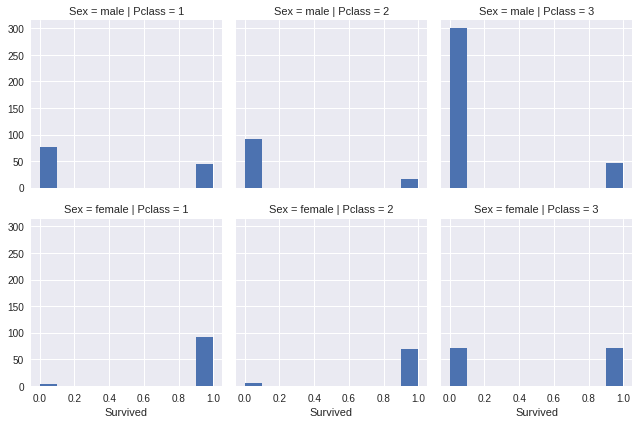

In [5]:
grid = sns.FacetGrid(data=df, row='Sex', col='Pclass')

_ = grid.map(plt.hist, "Survived")

In [6]:
discrete_features = ['Pclass', 'Sex', 'SibSp','Parch']

survivals = []

for feature in discrete_features:
    groups = df.copy().groupby(feature)
       
    survival_per_level = groups['Survived'].mean()
    
    survivals.append(survival_per_level)

In [7]:
survivals

[Pclass
 1    0.629630
 2    0.472826
 3    0.242363
 Name: Survived, dtype: float64, Sex
 female    0.742038
 male      0.188908
 Name: Survived, dtype: float64, SibSp
 0    0.345395
 1    0.535885
 2    0.464286
 3    0.250000
 4    0.166667
 5    0.000000
 8    0.000000
 Name: Survived, dtype: float64, Parch
 0    0.343658
 1    0.550847
 2    0.500000
 3    0.600000
 4    0.000000
 5    0.200000
 6    0.000000
 Name: Survived, dtype: float64]

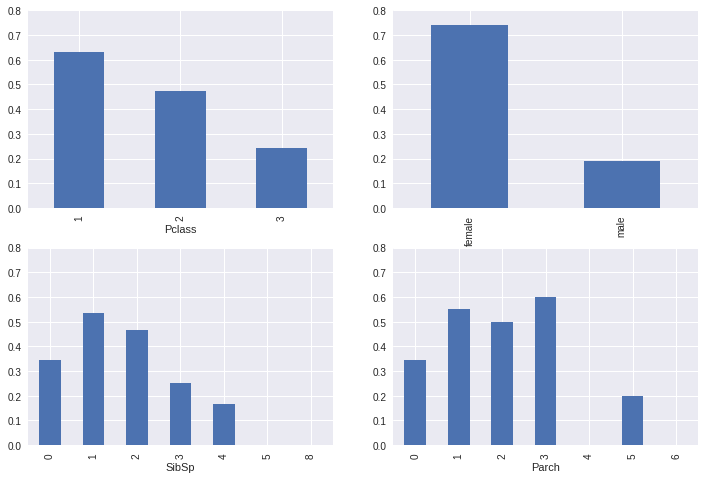

In [8]:
f, axes = plt.subplots(2,2)
f.set_size_inches(12,8)

for i, survival in enumerate(survivals):
    current_axis = axes[int(i/2)][i%2]
    survival.plot(kind='bar', ax=current_axis)
    current_axis.set_ylim(0,0.8)

(0, 200)

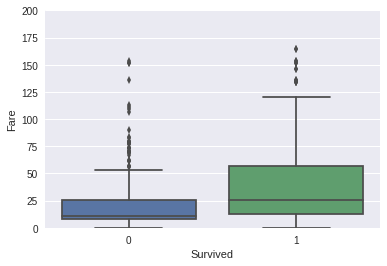

In [9]:
sns.boxplot(data=df, y='Fare', x='Survived')
plt.gca().set_ylim(0,200)

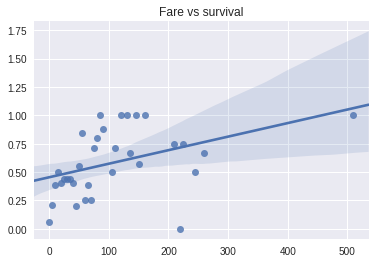

In [10]:
# Group by fare bins
fare_groups = df.groupby(by=lambda row: int(df.ix[row]['Fare'] / 5))
survival_per_fare = fare_groups['Survived'].mean()

sns.regplot(survival_per_fare.index.values * 5, survival_per_fare.values)
_ = plt.gca().set_title('Fare vs survival')

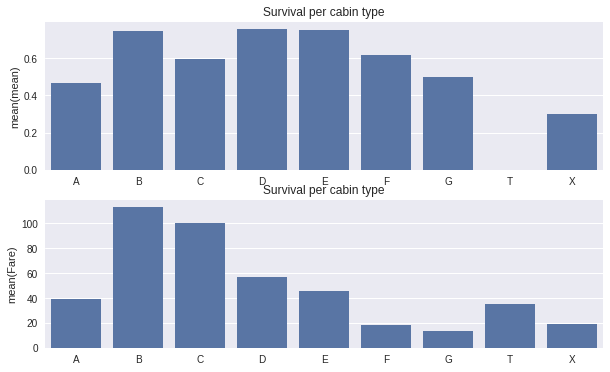

In [11]:
cabin_type = df['Cabin'].str.get(0).fillna('X')

# Group by Cabin types
cabin_groups = df.groupby(by=cabin_type)
survival_per_cabin = cabin_groups['Survived'].agg(['mean', 'count'])

f, axes = plt.subplots(2,1)
f.set_size_inches(10,6)
ax = sns.barplot(survival_per_cabin.index.values, survival_per_cabin['mean'], color=sns.color_palette()[0], ax=axes[0])
_ = ax.set_title('Survival per cabin type')

fare_per_cabin = cabin_groups['Fare'].mean()
ax = sns.barplot(fare_per_cabin.index.values, fare_per_cabin, color=sns.color_palette()[0], ax=axes[1])
_ = ax.set_title('Survival per cabin type')



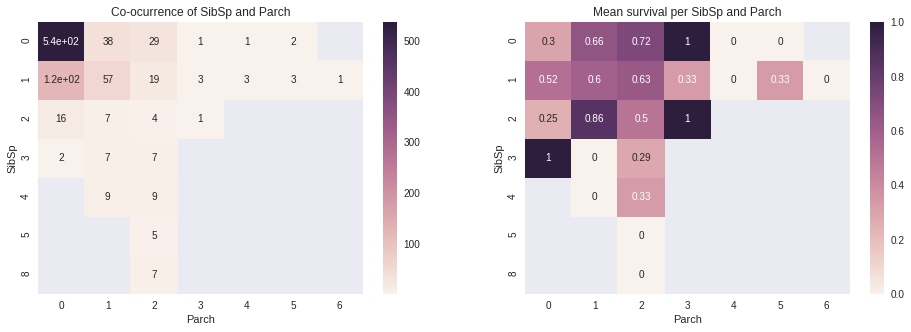

In [12]:
# Family factors:

survival_family_size = df.groupby(['SibSp', 'Parch'])['Survived'].aggregate(['mean', 'count'])
#sns.heatmap(df['SibSp'], df['Parch'], kind='hex')
#co_ocurrence = survival_family_size.pivot(index='SibSp', columns='Parch', values = 'count')


f, axes = plt.subplots(1,2)
f.set_size_inches(16,5)

co_ocurrence = survival_family_size['count'].unstack()
ax = sns.heatmap(co_ocurrence, ax=axes[0], annot=True)
ax.set_title('Co-ocurrence of SibSp and Parch')

survival = survival_family_size['mean'].unstack()
ax = sns.heatmap(survival, ax=axes[1], annot=True)
_ = ax.set_title('Mean survival per SibSp and Parch')

,mean,count
0,0.303538,537
1,0.552795,161
2,0.578431,102
3,0.724138,29
4,0.200000,15
5,0.136364,22
6,0.333333,12
7,0.000000,6
10,0.000000,7


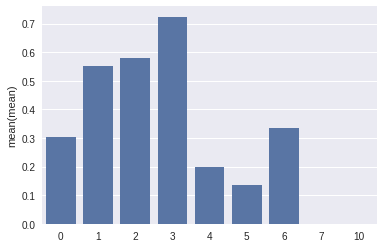

In [13]:
fam_size = df['SibSp'] + df['Parch']

survival_per_fam_size = df.groupby(fam_size)['Survived'].agg(['mean', 'count'])

sns.barplot(survival_per_fam_size.index,survival_per_fam_size['mean'], color=sns.color_palette()[0])
survival_per_fam_size

## Feature engineering:

* Fare scaled
* Sex has to be encoded into 0/1 -> LabelEncoder
* Pclass will remain as is
* SibSp and Parch - Sum
* Interaction terms: use [this preprocessor](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)
* Cabin: first letter -> custom encoder?

In [14]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.feature_extraction import DictVectorizer

In [15]:
df.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [16]:
Y = df['Survived']
X = df[df.columns[1:]]

## Extractors

The official way to handle heterogeneous columns seems to be using FeatureUnion. That, I understand, results in something like this:

In [21]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# Has this really not been implemented somewhere already????
class ColumnExtractor(BaseEstimator, TransformerMixin):
    
    def __init__(self, column):
        self.col = column
    
    def fit(self, df, y=None):
        return self
    
    def transform(self, df, y=None):
        # Respect the shape in pipelines
        vector = df[self.col].values.reshape(-1, 1)
        return vector

class InitialLetterExtractor(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, df, y=None):
        return self
    
    def transform(self, df, y=None):
        cabin = df.str.get(0).fillna('X')
        vector = cabin.values.reshape(-1, 1)
        return vector

fare_preproc = Pipeline([
        ('ext_fare', ColumnExtractor('Fare')),
        ('minmax', MinMaxScaler())        
    ])

sex_preproc = Pipeline([
        ('ext_sex', ColumnExtractor('Sex')),
        ('encode_sex', LabelEncoder())        
    ])

class_preproc = ColumnExtractor('Pclass')

familiy_preprocessor = FunctionTransformer(lambda X: (X['SibSp'] + X['Parch']).values.reshape(-1,1), validate=False)

cabin_preproc = Pipeline([
        ('ext_cab', ColumnExtractor('Cabin')),
        ('letter_cab', InitialLetterExtractor()),
        ('onehot_cab', OneHotEncoder())
    ])

from sklearn.tree import DecisionTreeClassifier

features = FeatureUnion([
                    ('fare', fare_preproc),
                    ('sex', sex_preproc),
                    ('class', class_preproc),
                    ('fam', familiy_preprocessor),
                    ('cabin', cabin_preproc)                    
                ])

pipeline = Pipeline([
        ('features', features),
        ('predict', DecisionTreeClassifier())
    ])

## sklearn_pandas

However, there is a module that provides a much more elegant syntax for using DataFrames into sklearn. 

A problem is that it goes straight to the ndarrays, so we can't use the convenient `.str` from Series

In [129]:
import numpy as np
from sklearn_pandas import DataFrameMapper

def get_initials(array):
    array[array.astype(str) == 'nan'] = 'X'
    initials = np.array(list(map(lambda x: x[0], array)))
    
    return initials     
    
def add_rowwise(df):
    family = df[:, 0] + df[:,1]
    return family

cabinpip = Pipeline([
                    ('initial', FunctionTransformer(get_initials, validate=False)), 
                    ('label', LabelEncoder()),
                    ('onehot', OneHotEncoder())
                ])

cabinpip.fit_transform(df['Cabin'])

/home/dani/anaconda3/envs/titanic/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


TypeError: fit_transform() takes 2 positional arguments but 3 were given

In [ ]:

mapper = DataFrameMapper([
        (['Fare'], MinMaxScaler()),
        ('Sex', LabelEncoder()),
        (['SibSp', 'Parch'], FunctionTransformer(add_rowwise)),
        ('Cabin', cabinpip)
    ])

mapper.fit_transform(X)